# Learned Post-Processing for Computarized Tomography

Computing the inverse of the Radon transform by means of the Filtered Back Projection (FBP) works well when the measurements where done for a high number of angles, however, this implies a lot of harmful radiation for the patients. Therefore the goal is to get good reconstructions with as few angles as possible.

The learned post-processing is a great example of how we can use Deep Learning and Convolutional Neural Networks for such an Inverse Problem. The main idea is to first apply some pseudo-inverse, in this case the FBP, and then use a deep Neural Network that was trained with many samples to improve the results coming from the pseudo-inverse. If our forward operator is $A:X\rightarrow Y$ and its pseudo inverse is $A^\dagger: Y\rightarrow X$ then

$$x^\delta = \Lambda_\theta (A^\dagger y^\delta)$$

where $\Lambda_\theta: X \rightarrow X$ is the network that makes the postprocessing.



## Exercise 1

**a)** Load the MNIST data set, in the same way it was done for the CNN example for classifying the digits, and create a data set consisting of pairs $(z_i, x_i)$ for training $\Lambda_\theta$, where $z_i=A^\dagger y_i, y_i = Ax_i+ \sigma \eta$, $\eta \sim \mathcal{N}(0,1)$, $A$ is the Radon transform operator and $A^\dagger$ the FBP operator. Inistially set $\sigma=10^{-2}$ but check what happens for different values.

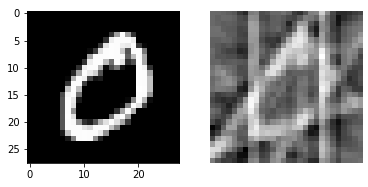

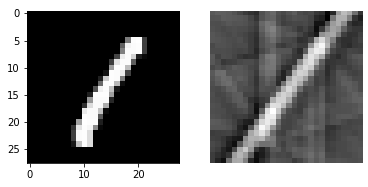

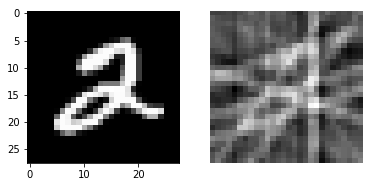

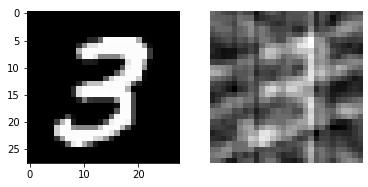

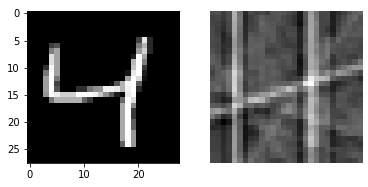

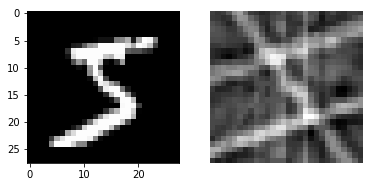

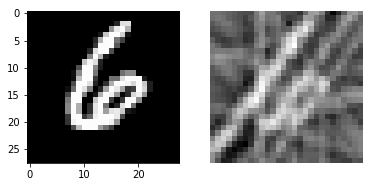

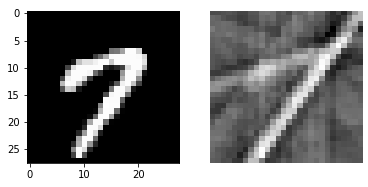

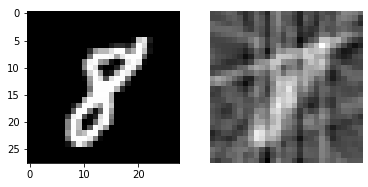

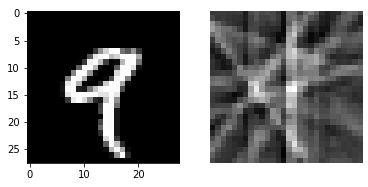

In [5]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.transform import radon
import numpy as np

%matplotlib inline

angles = 5
sigma = 1e-2
theta = np.linspace(0., 180., angles, endpoint=False)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Since we are not doing classification anymore we ignore the digit labels

x_train = x_train[:500,:,:]
y_train = y_train[:500]

x_test = x_train[:500,:,:]
y_test = y_test[:500]


def generate_z(x):
    z = []
    for xi in x:
        yi = radon(xi, theta=theta, circle=False)
        yi_delta = yi + np.random.randn(*yi.shape) * sigma
        zi = iradon(yi_delta, theta=theta, circle=False)
        z += [zi]
    return np.array(z)
        

z_train = generate_z(x_train)
z_test = generate_z(x_test)


for i in range(10):
    plt.figure()
    xi = x_train[y_train==i][0]
    zi = z_train[y_train==i][0]

    plt.subplot(1, 2, 1)
    plt.imshow(xi, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(zi, cmap='gray')

    plt.axis('off')

        
# using the full data set will take a lot of time so we are only going to se a subset
x_train = x_train[:5000,:,:]
z_train = z_train[:5000,:,:]
        

# data preparation (images should be 28 x 28 x 1 tensors)
img_rows = 28
img_cols = 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_train.shape[0], img_rows, img_cols, 1)
z_train = z_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
z_test = z_test.reshape(x_train.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

# normalize images to have values between 0 and 1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

z_train = z_train.astype('float32')/255
z_test = z_test.astype('float32')/255

**b)** Set $\Lambda_\theta$ to be a **U-Net** like neural network and train it.

In [6]:
from keras.layers import Conv2D, GaussianNoise, LeakyReLU, Input, BatchNormalization, Concatenate, UpSampling2D
from keras.models import Model

def unet(input_shape,
         noise=1.0/30,
         num_output_channels=1,
         num_channels_down=[16, 32],
         num_channels_up=[16, 32],
         num_channels_skip=[2, 2],
         filter_size_down=[3, 3, 3],
         filter_size_up=[3, 3, 3],
         filter_skip_size=1,
         act_fun=LeakyReLU,
         need1x1_up=True,
         need_bias=False):

    n_scales = len(num_channels_down)
    
    down_layers = []

    x = Input(shape=input_shape)
    out = x
    out = GaussianNoise(noise)(out)

    for i in range(len(num_channels_down)):
        out = Conv2D(filters=num_channels_down[i], kernel_size=filter_size_down[i], strides=(2, 2), use_bias=need_bias, padding='same')(out)
        out = BatchNormalization()(out)
        out = act_fun()(out)

        out = Conv2D(num_channels_down[i], kernel_size=filter_size_down[i], use_bias=need_bias, padding='same')(out)
        out = BatchNormalization()(out)
        out = act_fun()(out)

        down_layers += [out]

    for i in range(len(num_channels_up)):
        if num_channels_skip[-(i + 1)] != 0:
            skip = Conv2D(num_channels_skip[-(i + 1)], filter_skip_size, use_bias=need_bias, padding='same')(down_layers[-(i + 1)])
            skip = BatchNormalization()(skip)
            skip = act_fun()(skip)
            out = Concatenate()([out, skip])

        out = UpSampling2D(size=(2, 2))(out)
        out = BatchNormalization()(out)
        out = Conv2D(num_channels_up[-(i+1)], filter_size_up[-(i+1)], use_bias=need_bias, padding='same')(out)
        out = BatchNormalization()(out)
        out = act_fun()(out)

        if need1x1_up:
            out = Conv2D(num_channels_up[-(i+1)], kernel_size=1, use_bias=need_bias, padding='same')(out)
            out = BatchNormalization()(out)
            act_fun()(out)

    out = Conv2D(num_output_channels, kernel_size=1, activation='sigmoid', padding='same')(out)

    model = Model(inputs=x, outputs=out)
    return model


model = unet(input_shape=input_shape)
model.compile(loss='mse', optimizer='adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 28, 28, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 16)   144         gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 14, 14, 16)   64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [7]:
model.fit(z_train, x_train, validation_data=(z_test, x_test), epochs=20, verbose=1)

Train on 500 samples, validate on 500 samples
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.1765 - val_loss: 0.2139
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1035 - val_loss: 0.1420
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.0720 - val_loss: 0.0867
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0536 - val_loss: 0.0622
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0422 - val_loss: 0.0499
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0349 - val_loss: 0.0409
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0308 - val_loss: 0.0405
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0271 - val_loss: 0.0281
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0246 - val_loss: 0.0270
Epoch 10/20
500/500 [===============

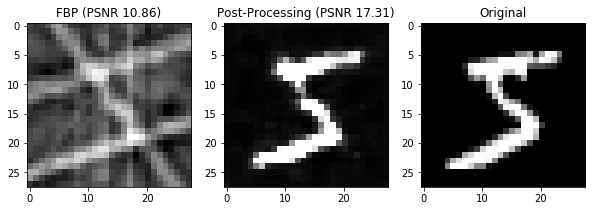

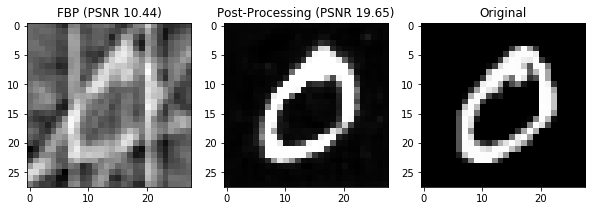

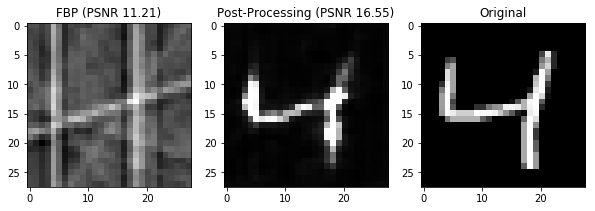

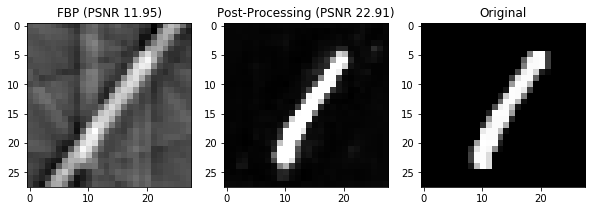

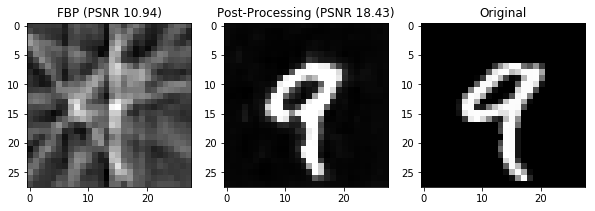

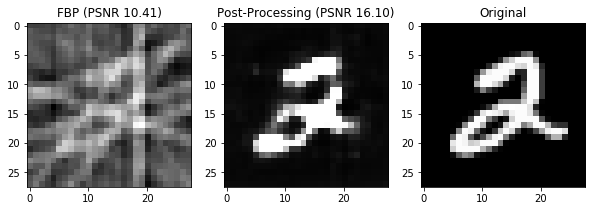

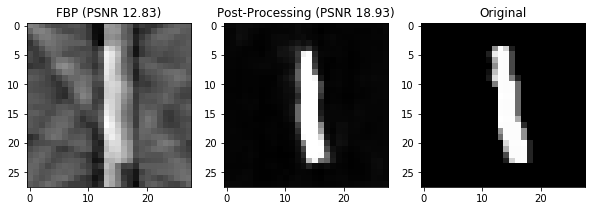

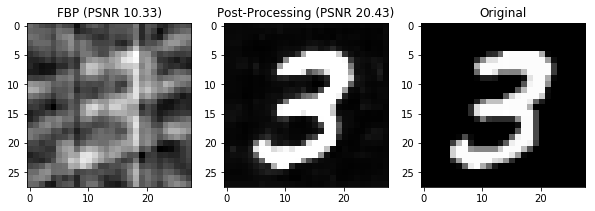

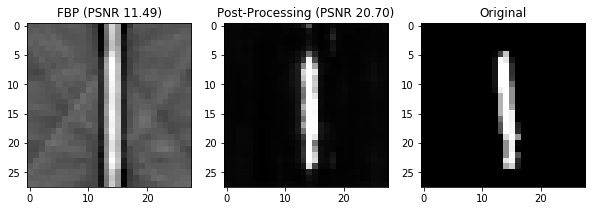

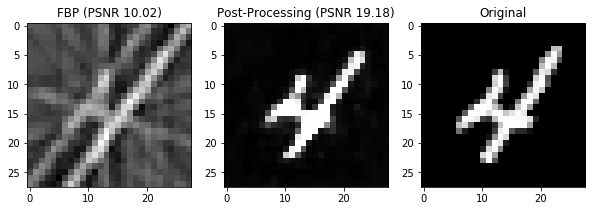

In [14]:
from skimage.measure import compare_psnr


for i in range(10):
    plt.figure(figsize=(10,5))
    xi = model.predict(np.array([z_test[i]]))

    plt.subplot(1, 3, 1)
    plt.imshow(z_test[i][:,:,0], cmap='gray')
    plt.title('FBP (PSNR %.2f)' % compare_psnr(z_test[i][:,:,0], x_test[i][:,:,0], data_range=1))

    plt.subplot(1, 3, 2)
    plt.imshow(xi[0,:,:,0], cmap='gray')
    plt.title('Post-Processing (PSNR %.2f)' % compare_psnr(xi[0,:,:,0], x_test[i][:,:,0], data_range=1))
    plt.subplot(1, 3, 3)
    plt.imshow(x_test[i][:,:,0], cmap='gray')
    plt.title('Original')